### Final ddrobot cells start from here

In [1]:
# class implementation of robo2links controller GUI
import numpy as np
import paho.mqtt.client as mqtt
import tkinter as tk
from tkinter import *
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
from matplotlib.animation import FuncAnimation

In [ ]:
# use code from this link
# https://stackoverflow.com/questions/60413174/rotating-rectangles-around-point-with-matplotlib

In [2]:
class RotatingRectangle(Rectangle):
    def __init__(self, xy, width, height, rel_point_of_rot, **kwargs):
        super().__init__(xy, width, height, **kwargs)
        self.rel_point_of_rot = rel_point_of_rot
        self.xy_center = self.get_xy()
        self.set_angle(self.angle)

    def _apply_rotation(self):
        angle_rad = self.angle * np.pi / 180
        m_trans = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                            [np.sin(angle_rad), np.cos(angle_rad)]])
        shift = -m_trans @ self.rel_point_of_rot
        self.set_xy(self.xy_center + shift)

    def set_angle(self, angle):
        self.angle = angle
        self._apply_rotation()

    def set_rel_point_of_rot(self, rel_point_of_rot):
        self.rel_point_of_rot = rel_point_of_rot
        self._apply_rotation()

    def set_xy_center(self, xy):
        self.xy_center = xy
        self._apply_rotation()

In [3]:
# ----- wheel parameters -------
LEFT_WHEEL = 0
RIGHT_WHEEL = 1
WHEEL_RADIUS = 0.08
WHEEL_DIAMETER = 2*WHEEL_RADIUS
WHEEL_THICKNESS = 0.04
WHEEL_SEPARATION = 0.45
BASE_LENGTH = 0.65
BASE_WIDTH = 0.55
EYE_THICKNESS = 0.04
EYE_DIAMETER = 0.1


In [4]:
# def rotate_points(angle,xy,center):
#     angle_rad = angle * np.pi / 180
#     m_trans = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
#                         [np.sin(angle_rad), np.cos(angle_rad)]])
#     shift = m_trans @ xy    
#     return np.add(shift,center)
    

Connecting to mqtt broker
Cleaning up.. 


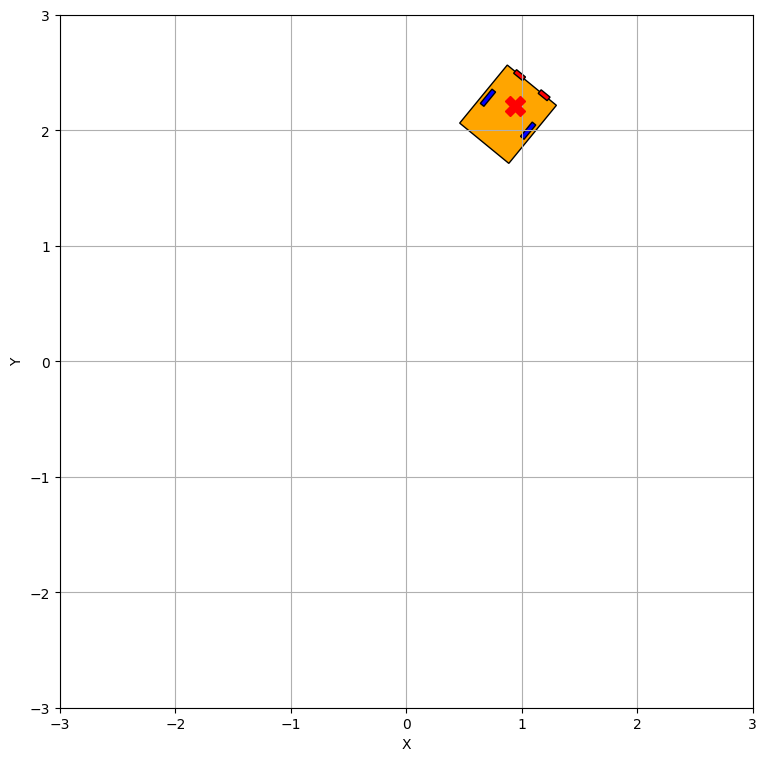

In [5]:
# GUI for differential-drive robot
class ddrController:

    def __init__(self, root):
        
        screen_width = 800
        screen_height = 800
        self.TFont1 = ("Consolas",14)
        self.TFont2 = ("Consolas",16)
#         self.TFont1 = ("Calibri",14)
#         self.TFont2 = ("Calibri",16)
        
        self.online = True  # change to True to connect to NETPIE
        self.rad2deg = 180/np.pi
        
        root.title("Differential-Drive Robot Controller")
        root.protocol("WM_DELETE_WINDOW", self.on_close)
        root.geometry(str(screen_width)+'x'+str(screen_height))
        mainframe = ttk.Frame(root, padding="3 3 12 12")
        mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        root.columnconfigure(0, weight=1)
        root.rowconfigure(0, weight=1)
        cvrowspan = 15  # canvas row and column span.
        cvcolspan = 8  

        self.enable_txt = StringVar()
        self.xg_txt = StringVar()   # goal XY coordinate 
        self.yg_txt = StringVar()
        self.xt_txt = StringVar()  # XY coordinate of robot
        self.yt_txt = StringVar()
        self.theta_txt = StringVar() # orientation of robot
        self.trackmsg_txt = StringVar()
        self.trackmsg_txt.set("Ready")
        
        
        # send command to robot controller
        self.ddr_txt = StringVar()
        ddrcmd_entry = ttk.Entry(mainframe, textvariable=self.ddr_txt)
        ddrcmd_entry.grid(column=0, row=cvrowspan+5,sticky=(W, E))
        ttk.Button(mainframe, text="Send", command=self.send_ddr).grid(column=1, row=cvrowspan+5, sticky=W)

        
       
        #   ------ robot enable group.  ------------------------------
        enframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        enframe.grid(column=cvcolspan, row=0) #column=cvcolspan,row=0)        
        # self.feedback_txt.set("1")  
        ttk.Label(enframe, text="Robot          ", 
                  font=self.TFont1,foreground='maroon').grid(column=0, row=0, sticky=(N,W))        
        self.disable_rb = (ttk.Radiobutton(enframe,text="Disable", variable=self.enable_txt,
                                     value="0",command=self.send_cmd_disable).
                                     grid(column=0, row=1, sticky=W))
        self.enable_rb = (ttk.Radiobutton(enframe, text="Enable", variable=self.enable_txt,
                                     value="1",command=self.send_cmd_enable).
                                     grid(column=0, row=2, sticky=W))


        
        #  -------- cartesian coordinate frame ------------------
        
        xyframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        xyframe.grid(column=cvcolspan,row=3)
        ttk.Label(xyframe, text="XY coordinates", 
                  font=self.TFont1,foreground='green').grid(column=0, row=0, sticky=W)
        ttk.Label(xyframe, text="X goal: ", 
                  font=self.TFont1,foreground='blue').grid(column=0, row=1, sticky=W)
        ttk.Label(xyframe, textvariable=self.xg_txt, 
                  font=self.TFont1,foreground='teal').grid(column=1, row=1, sticky=W)
        ttk.Label(xyframe, text="Y goal: ", 
                  font=self.TFont1,foreground='blue').grid(column=0, row=2, sticky=W)
        ttk.Label(xyframe, textvariable=self.yg_txt, 
                  font=self.TFont1,foreground='teal').grid(column=1, row=2, sticky=W)        
        ttk.Label(xyframe, textvariable=self.trackmsg_txt, 
                  font=self.TFont1,foreground='olive').grid(column=0, row=3, sticky=W)        
        
        ttk.Label(xyframe, text="X robot: ", 
                  font=self.TFont1,foreground='maroon').grid(column=0, row=4, sticky=W)
        ttk.Label(xyframe, textvariable=self.xt_txt, 
                  font=self.TFont1,foreground='teal').grid(column=1, row=4, sticky=W)
        ttk.Label(xyframe, text="Y robot: ", 
                  font=self.TFont1,foreground='maroon').grid(column=0, row=5, sticky=W)
        ttk.Label(xyframe, textvariable=self.yt_txt, 
                  font=self.TFont1,foreground='teal').grid(column=1, row=5, sticky=W)
        ttk.Label(xyframe, text="Theta : ", 
                  font=self.TFont1,foreground='maroon').grid(column=0, row=6, sticky=W)
        
        ttk.Label(xyframe, textvariable=self.theta_txt, 
                  font=self.TFont1,foreground='orangered').grid(column=1, row=6, sticky=W)
        
        
        # enable function would do the job ?
#         ttk.Button(xyframe, text="Move", command=self.send_goal).grid(column=0, 
#                                                         row=6, sticky=W) 

        # ------- draw path control ------
        self.drawmode = BooleanVar()
#         self.showws = BooleanVar()
        self.showhist = BooleanVar()
        drawframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        drawframe.grid(column=cvcolspan,row=4)
        ttk.Label(drawframe, text="Plot control         ", 
                  font=self.TFont1,foreground='olive').grid(column=0, row=0, sticky=W)
        ttk.Checkbutton(drawframe, text="draw path",variable=self.drawmode).grid(column=0, 
                                                                row=1, sticky=W)
        ttk.Button(drawframe, text="Clear", command=self.clear_path).grid(column=0, 
                                     row=2, sticky=W)        
#         ttk.Checkbutton(drawframe, text="show workspace",variable=self.showws).grid(column=0, 
#                                     row=3, sticky=W)
        ttk.Checkbutton(drawframe, text="show history",variable=self.showhist).grid(column=0, 
                                    row=4, sticky=W)

#         self.draw_btn = ttk.Button(drawframe, text="Clear", command=self.toggle_draw).grid(column=0, 
#                                     row=1, sticky=W) # toggle between "Draw" and "Clear"
        
        ttk.Label(mainframe, text="dew.ninja 2023", font=self.TFont1, 
                  foreground="darkred").grid(column=2,row=5,sticky=W)
        
        # ------ canvas for differential-drive robot display  ----------
        self.x_vec = []  # used for path draw
        self.y_vec = []
        self.xg_vec = []
        self.yg_vec = []
        self.fig, self.ax = plt.subplots(figsize=(9,9))
        cif = self.fig.canvas.mpl_connect('button_press_event',self.mouse_event) 

#         self.point_of_rotation = np.array([0, self.link_height/2])         
        # -----------------------------------------
        
#         self.time_step = 0.0
#         self.time_vec = []
#         self.y1_vec = []
#         self.y2_vec = []
#         self.y3_vec = []
       
#         self.fig, self.axes  = plt.subplots(2,1)
#         self.ax1, self.ax2 = self.fig.get_axes()
        self.canvas = FigureCanvasTkAgg(self.fig, master=mainframe)
        self.canvas.get_tk_widget().grid(row=0,column=0, rowspan=cvrowspan, columnspan=cvcolspan, sticky=W)
        self.an1 = FuncAnimation(self.fig, self.animate, interval=1000,cache_frame_data=False )
#      save_count=MAX_FRAMES or cache_frame_data=False
        

        for child in mainframe.winfo_children(): 
            child.grid_configure(padx=5, pady=5)
        
        self.Client_ID = "" # put in your NETPIE info 
        self.User = "
        self.Password = ""    
        self.broker = "broker.netpie.io"
        self.port = 1883     
        if self.online:
            self.mqtt_connect()

        self.enable = 0  # will be updated by ESP32
        
        self.xg = 0.0  # goal coordinate. Start at (0.0,2.0)
        self.yg = 2.0
        self.xt = 0.0   # tool coordinate
        self.yt = 0.0
        self.theta = 0.0  # orientation
        
        # robot parameters
        self.LEFT_WHEEL = 0
        self.RIGHT_WHEEL = 1
        self.WHEEL_RADIUS = 0.08
        self.WHEEL_DIAMETER = 2*self.WHEEL_RADIUS
        self.WHEEL_THICKNESS = 0.04
        self.WHEEL_SEPARATION = 0.45
        self.BASE_LENGTH = 0.65
        self.BASE_WIDTH = 0.55
        self.EYE_THICKNESS = 0.04
        self.EYE_DIAMETER = 0.1
        

        
#         self.xg_txt.set(str(round(self.xg,2)))
#         self.yg_txt.set(str(round(self.yg,2)))
        

    def mqtt_connect(self):
        print("Connecting to mqtt broker")
        try:
            self.client = mqtt.Client(client_id=self.Client_ID,
                         transport='tcp',
                         protocol=mqtt.MQTTv311,
                         clean_session=True)
            self.client.username_pw_set(self.User,self.Password)
            self.client.connect(self.broker, port=self.port, keepalive=60)
            self.client.subscribe("@msg/update")
            #self.client.subscribe("@msg/shadowdata")
            self.client.on_message = self.on_message
            self.client.loop_start()
        except:
            print("Problem connecting to mqtt broker")

    def on_message(self,client, userdata, message):
        self.rcvd_msg = str(message.payload.decode("utf-8"))
        self.rcvd_topic = message.topic
#         #print("message received ", self.rcvd_msg)
#         #print("message topic=",message.topic)
        self.xt_txt = StringVar()  # XY coordinate of robot
        self.yt_txt = StringVar()
        self.theta_txt = StringVar() # orientation of robot

        if self.rcvd_topic == "@msg/update":
            parm_data = self.rcvd_msg.split(',')
            # strings for GUI update
            self.enable_txt.set(parm_data[3])
            self.xt_txt.set(parm_data[0])
            self.yt_txt.set(parm_data[1])
            self.theta_txt.set(parm_data[2])
            
            # update parameters
            self.enable = int(parm_data[3])
            self.trackmode = int(parm_data[4])
            if self.trackmode:
                self.trackmsg_txt.set("Tracking in progress")
            else:
                self.trackmsg_txt.set("Ready")
                
            self.xt = float(parm_data[0])
            self.yt = float(parm_data[1])
            self.theta = float(parm_data[2])

       
            
    def animate(self,i):
        if not self.showhist.get():  # delete previous plot or not
            self.ax.cla()
        self.ax.set_aspect('equal')
        self.ax.set_xlim(-3.0,3.0)
        self.ax.set_ylim(-3.0,3.0)
        self.ax.set_xlabel("X")
        self.ax.set_ylabel("Y")

#         self.ax.plot(0, 0,  color='orange', marker='o', markersize=30)
        base_height = self.BASE_WIDTH
        base_width = self.BASE_LENGTH
#         fig, ax = plt.subplots(figsize=(10,10))
        #ax.plot(0, 0,  color='b', marker='o', markersize=30)

        # find 5 points of robot related to theta
        # center, left-right wheels, left-right eyes (front size)
        x_center = self.xt
        y_center = self.yt
        theta = self.theta*self.rad2deg
#         print("{},{},{}".format(x_center,y_center,theta))


        robot_point_of_rotation = np.array([base_width/2, base_height/2]) # mid point

        robot_base = RotatingRectangle((x_center,y_center), width=base_width, height=base_height, 
                                    rel_point_of_rot=robot_point_of_rotation,
                                    angle=theta, edgecolor='black', facecolor='orange')
        self.ax.add_patch(robot_base)

        # left wheel 
        x_lw = 0
        y_lw = self.WHEEL_SEPARATION/2

        # right wheel
        x_rw = 0
        y_rw = - self.WHEEL_SEPARATION/2

        # left eye
        x_le = self.BASE_LENGTH/2
        y_le = self.BASE_WIDTH/4

        # right eye
        x_re = self.BASE_LENGTH/2
        y_re = -self.BASE_WIDTH/4

        # rotate these points relative to theta
        xy_lw = self.rotate_points(theta,(x_lw,y_lw),(x_center,y_center))
        xy_rw = self.rotate_points(theta,(x_rw,y_rw),(x_center,y_center))
        xy_le = self.rotate_points(theta,(x_le,y_le),(x_center,y_center))
        xy_re = self.rotate_points(theta,(x_re,y_re),(x_center,y_center))
        # xy_lw = (x_lw,y_lw)
        # xy_rw = (x_rw,y_rw)
        # xy_le = (x_le,y_le)
        # xy_re = (x_re,y_re)
        wheel_height = self.WHEEL_THICKNESS
        wheel_width = self.WHEEL_DIAMETER

        # left wheel
        lw_point_of_rotation = np.array([wheel_width/2, wheel_height/2]) # mid point of left wheel
        robot_lw = RotatingRectangle(xy_lw, width=wheel_width, height=wheel_height, 
                                    rel_point_of_rot=lw_point_of_rotation,
                                    angle=theta, edgecolor='black', facecolor='blue')
        self.ax.add_patch(robot_lw)

        # right wheel
        rw_point_of_rotation = np.array([wheel_width/2, wheel_height/2]) # mid point of right wheel
        robot_rw = RotatingRectangle(xy_rw, width=wheel_width, height=wheel_height, 
                                    rel_point_of_rot=rw_point_of_rotation,
                                    angle=theta, edgecolor='black', facecolor='blue')
        self.ax.add_patch(robot_rw)

        # ---- add eyes ---------
        eye_height = self.EYE_DIAMETER
        eye_width = self.EYE_THICKNESS

        # left eye
        le_point_of_rotation = np.array([eye_width/2, eye_height/2]) # mid point of left eye
        robot_le = RotatingRectangle(xy_le, width=eye_width, height=eye_height, 
                                    rel_point_of_rot=le_point_of_rotation,
                                    angle=theta, edgecolor='black', facecolor='red')
        self.ax.add_patch(robot_le)

        # right eye
        re_point_of_rotation = np.array([eye_width/2, eye_height/2]) # mid point of left eye
        robot_re = RotatingRectangle(xy_re, width=eye_width, height=eye_height, 
                                    rel_point_of_rot=re_point_of_rotation,
                                    angle=theta, edgecolor='black', facecolor='red')
        self.ax.add_patch(robot_re)

        self.ax.grid(True)


        self.ax.plot(self.xg, self.yg,  color='r', marker='X', markersize=15) # target position

#         if self.showws.get(): # draw workspace
#             robo_ws = plt.Circle((0.0,0.0),2, color='m',fill=False)
#             self.ax.add_patch(robo_ws)
            
        if self.drawmode.get():   # draw path
            self.x_vec.append(self.xt)
            self.y_vec.append(self.yt)
            self.ax.plot(self.x_vec,self.y_vec,'blue')
            self.ax.plot(self.xg_vec,self.yg_vec,'red',marker='X',linestyle='None',markersize=15)
#        print("Animating")


    def send_ddr(self, *args):  # changed to send arbitrary command
        cmd_txt = self.ddr_txt.get()
        if self.online:
            self.client.publish("@msg/cmd",cmd_txt)
        
    def send_cmd_disable(self, *args):
        if self.online:
            cmd_txt = "enable=0"
            self.client.publish("@msg/cmd",cmd_txt)
    def send_cmd_enable(self, *args):
        if self.online:
            cmd_txt = "enable=1"
            self.client.publish("@msg/cmd",cmd_txt)

    def send_goal(self, *args): # send step or track command to robot controller
        if self.online:
            cmd_txt = "ltrack="+str(round(self.xg,3))+","+str(round(self.yg,3))
            self.client.publish("@msg/cmd",cmd_txt)
            

    def clear_path(self, *args):         
        self.x_vec = []
        self.y_vec = []
        self.xg_vec = []
        self.yg_vec = []
#     def show_workspace(self, *args):         
#         pass

    def mouse_event(self,event):
        self.xg = round(event.xdata,3)
        self.yg = round(event.ydata,5)
        self.xg_txt.set(str(self.xg))
        self.yg_txt.set(str(self.yg))
        if self.drawmode.get():   # draw path
            self.xg_vec.append(self.xg)
            self.yg_vec.append(self.yg)        
        self.send_goal()
#         self.ikine()

    def rotate_points(self,angle,xy,center):
        angle_rad = angle * np.pi / 180
        m_trans = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                        [np.sin(angle_rad), np.cos(angle_rad)]])
        shift = m_trans @ xy    
        return np.add(shift,center)
    

        
    def on_close(self):
        print("Cleaning up.. ")
        if self.online:
            self.client.loop_stop()
            self.client.disconnect()
        root.destroy()

root = Tk()
ddrController(root)
root.mainloop()
    